# A Bayesian Network to model the effects of an epidemic on a nation
### Student: Andrea Rossolini <br> Fundamentals of Artificial Intelligence and Knowledge Representation (mod. 3)

In the following notebook I developed a highly simplified Bayesian network to model the main consequence of a pandemic breakout in a nation, based on its population, density, GDP and so on.

The network is based on the famous SIR model, each letter denotes a state of individuals in a population: 
<ul>
    <li>S: number of susceptible</li>
    <li>I: number of infected</li>
    <li>R: number of removed</li>
</ul>

The last state of this model can be devided in two different states: <i>recovered</i> and <i>dead</i>.
Thanks to this extansion the network that we are suppose to build can be extended with more concepts.

Such a model should be represented with a probabilistic reasoning model over time, to simplify this process I decided to model the consequence of a pandemic after defined period of time. Thus the following network represent a static model.

<b>Note</b><br>
The model takes as example the epidemic of COVID-19 and its effects on a nation in a time frame of two months.
The model, as said before, is over semplified, it does not take into account the economic damages that an epidemy can bring to a country, the social behaviour before and after the pandemic, the observance of the rules (social distances, wearing masks, compilance with a possible lockdown and so on), domestic or international turism and so forth.

In this project is used the library <b>pgmpy</b>.<br>
By the fact there not exists complete data from which pgmpy can learn to build the network; I created some artificious values, while other are taken from different sources (see at the bottom).
To simplify this work some continous variables had been devided in group.

In [1]:
import numpy as np
from scipy.stats import beta
from scipy.integrate import simps
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

from IPython.display import Image

Starting from the SIRD model explained above we can infer different features.<br>

<!-- bambini sotto i 12 mesi, persone con particolari sistemi immunitari, persone che vivono fenomeni di isolamento (hikikomori, gravi fenomeni di ipocondria con ricadute psicologiche, ecc..)-->

<br>
<ul>
    <li><b>Dens</b> = Density (pop./km^2):</li>
        <ul>
            <li>very low (< 30 e.g. Canada) 48/195</li>
            <li>low ([30,100] e.g. Brazil or USA)  64/195</li>
            <li>Medium ([100,300] e.g. Italy) 55/195</li>
            <li>High ([300,600] e.g. Netherlands) 18/195</li>
            <li>very high (> 600 e.g. Bangladesh) 10/195</li>
        </ul>
    <li><b>Pop</b> = population
        <ul>
            <li>very low (< 1,000,000 e.g. Luxemburg) 39/195</li>
            <li>low ([1, 10] million e.g. Austria) 66/195</li>
            <li>medium ([10, 100] million e.g. Italy) 76/195</li>
            <li>High ([100m, 1b]  e.g. Brazil) 12/195</li>
            <li>Very High ([> 1b] e.g. India) 2/195</li>
        </ul>
    </li>
    <li><b>RP</b>  = Restriction Policies
        <ul>
            <li>None   (e.g. herd immunity)</li>
            <li>Light  (e.g. mask mandatory in public spaces, ban on gathering)</li>
            <li>Medium (e.g. Lockdown with exceptions for workers, travel restrictions)</li>
            <li>Severe (e.g. Lockdown including productive activities, country isolation)</li>
            <li>Extreme (e.g. Martial law)</li>
        </ul>
    </li>
    <li><b>GDP</b> = Gross Domesti product</li>
    <ul>
        <li>Low  (< 100b e.g. Luxemburg) 131/165</li>
        <li>Medium ([100b, 1t] e.g. Netherlands) 48/195</li>
        <li>High (> 1t e.g. Italy) 16/195</li>
    </ul>
    <li><b>S</b>  = Susceptible: percentage of population that can get sick (people cannot be susceptible for different reasons as immunity, life style, age ...)</li>
    <ul>
        <li>medium (at least 75% of population)</li>
        <li>high (at least 90% " ")</li>
    </ul>
    <li><b>Age</b> = Average Age</li>
    <ul>
        <li>young  (< 20) 40/230 </li>
        <li>avg    ([20, 40]) 140/230</li>
        <li>old    (> 40) 50/230</li>
    </ul>
    <li><b>I</b> = percentage of susceptibles Infected</li>
    <ul>
        <li> Low (< 0.3% e.g. Mongolia) </li>
        <li> Medium ([0.3,0.8%] e.g. Italy)</li>
        <li> High (>0.8% e.g. USA)</li>
    </ul>
    <li><b>HC</b> = Health Care system overall performances </li>
    <ul>
        <li>weak</li> <-- la probabilità è nel quadernino --!>
        <li>strong</li>
    </ul>
    <li><b>De</b> = Percentage of deaths </li>
    <ul>
        <li>Low  (< 4% of infected died)</li> 
        <li>High (> 4% of infected died)</li>
    </ul>
    <li><b>Re</b> = Percentage of recovered </li>
    <ul>
        <li>Low  (< 50% of infected recovered)</li>
        <li>High (> 50% of infected recovered)</li>
    </ul>
</ul>

# 1. Model definition


It is possible to define the network strucure according to the features defined above. In the following cells it is explained how the network was conceived.

Using pgmpy we can simply wrote:

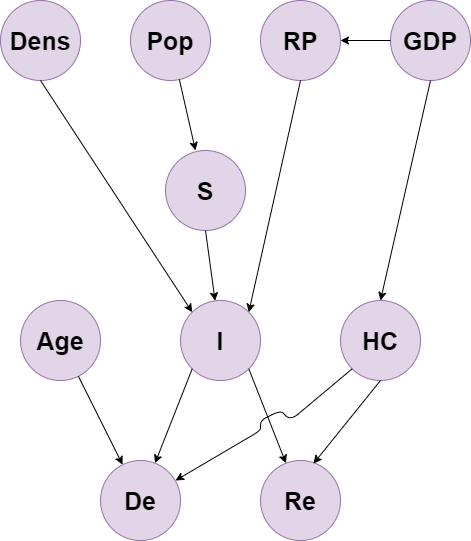

In [2]:
model = BayesianModel([('Dens', 'I'), ('Pop', 'S'), ('GDP', 'RP'), ('GDP', 'HC'),
                       ('RP', 'I'), ('S', 'I'), ('Age', 'De'), ('I', 'De'),
                       ('I', 'Re'), ('HC', 'De'), ('HC', 'Re')])
Image(filename="../res/chart.png")

Now we must define the values for the conditional probability tables: <b> The numbers that we use are rather arbitrary guesses and we do not pretend them to be anyhow realistic.</b>
<br>For the node without parents (density, population, GDP, average age of each country) is simple: I used the data from  [1], [2], [3], [4].

In [3]:
# Defining CPD of nodes without parents
den_cpd = TabularCPD(variable='Dens',variable_card=5, 
                    values=[[0.24615384615384617], [0.3282051282051282], [0.28205128205128205], [0.09230769230769231], [0.05128205128205128]],
                    state_names={'Dens': ['Very_low', 'Low', 'Medium', 'High', 'Very_high']})
pop_cpd = TabularCPD(variable='Pop',variable_card=5, 
                    values=[[0.2], [0.3384615384615385], [0.38974358974358975], [0.06153846153846154], [0.010256410256410256]],
                    state_names={'Pop': ['Very_low', 'Low', 'Medium', 'High', 'Very_high']})
gdp_cpd = TabularCPD(variable='GDP',variable_card=3, 
                    values=[[0.6717948717948717], [0.24615384615384617], [0.08205128205128205]],
                    state_names={'GDP': ['Low', 'Medium', 'High']})
age_cpd = TabularCPD(variable='Age',variable_card=3, 
                    values=[[0.17391304347826086], [0.6086956521739131], [0.21739130434782608]],
                    state_names={'Age': ['Young', 'Avg', 'Old']})

model.add_cpds(den_cpd, pop_cpd, gdp_cpd, age_cpd)

In the following cell <i>Susceptible</i> and <i>Health Care system</i> and <i>Restriction Policies</i> are defined.
The first one is infuenced only by the population and it has no other relation with other net's features.


In [4]:
# Defining CPD of nodes with one parent
sus_cpd = TabularCPD(variable='S',variable_card=2, 
                     values=[[0.3, 0.35, 0.4, 0.45, 0.50], [0.7, 0.65, 0.6, 0.55, 0.5]],
                     evidence=['Pop'],
                     evidence_card=[5],
                     state_names={'S': ['Medium', 'High'],
                                 'Pop': ['Very_low', 'Low', 'Medium', 'High', 'Very_high']})
HC_cpd = TabularCPD(variable='HC',variable_card=2, 
                     values=[[0.83, 0.42, 0.05], [0.17, 0.58, 0.95]],
                     evidence=['GDP'],
                     evidence_card=[3],
                     state_names={'HC': ['Weak', 'Strong'],
                                 'GDP': ['Low', 'Medium', 'High']})
RP_cpd = TabularCPD(variable='RP',variable_card=5,
                     values=[[0.29, 0.21, 0.12], 
                             [0.32, 0.37, 0.28], 
                             [0.19, 0.26, 0.39], 
                             [0.11, 0.13, 0.205], 
                             [0.09, 0.03, 0.005]],
                     evidence=['GDP'],
                     evidence_card=[3],
                     state_names={'RP': ['None', 'Light', 'Normal', 'Severe', 'Extreme'],
                                 'GDP': ['Low', 'Medium', 'High']})

model.add_cpds(sus_cpd, HC_cpd, RP_cpd)

In [5]:
#CANCELLA
S = [0.5, 0.75]
Dens = [1.5, 2, 3, 4, 4.5]
RP = [1, 0.5, 0, -0.5, -1]
min_ = 1.5

res = []
for es in S :
    for d in Dens:
        for rp in RP:
            tmp = es+d+rp
            if tmp < min_ :
                tmp=min_
            res.append(tmp)
print(res)
print(len(res))
res.sort()
for n, elem in enumerate(res):
    if n == 0 or elem != res[n-1] :
        print("{0} - count {1}".format(elem, res.count(elem)))

[3.0, 2.5, 2.0, 1.5, 1.5, 3.5, 3.0, 2.5, 2.0, 1.5, 4.5, 4.0, 3.5, 3.0, 2.5, 5.5, 5.0, 4.5, 4.0, 3.5, 6.0, 5.5, 5.0, 4.5, 4.0, 3.25, 2.75, 2.25, 1.75, 1.5, 3.75, 3.25, 2.75, 2.25, 1.75, 4.75, 4.25, 3.75, 3.25, 2.75, 5.75, 5.25, 4.75, 4.25, 3.75, 6.25, 5.75, 5.25, 4.75, 4.25]
50
1.5 - count 4
1.75 - count 2
2.0 - count 2
2.25 - count 2
2.5 - count 3
2.75 - count 3
3.0 - count 3
3.25 - count 3
3.5 - count 3
3.75 - count 3
4.0 - count 3
4.25 - count 3
4.5 - count 3
4.75 - count 3
5.0 - count 2
5.25 - count 2
5.5 - count 2
5.75 - count 2
6.0 - count 1
6.25 - count 1


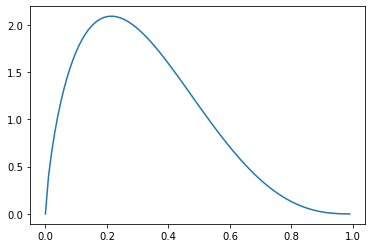

[0.00000000e+00 3.96088918e-01 6.47798758e-01 8.53609258e-01
 1.02940623e+00 1.18239701e+00 1.31677309e+00 1.43531606e+00
 1.54003263e+00 1.63245650e+00 1.71381053e+00 1.78510160e+00
 1.84717988e+00 1.90077786e+00 1.94653705e+00 1.98502690e+00
 2.01675866e+00 2.04219567e+00 2.06176128e+00 2.07584494e+00
 2.08480705e+00 2.08898287e+00 2.08868561e+00 2.08420905e+00
 2.07582968e+00 2.06380845e+00 2.04839236e+00 2.02981564e+00
 2.00830096e+00 1.98406028e+00 1.95729577e+00 1.92820043e+00
 1.89695881e+00 1.86374748e+00 1.82873559e+00 1.79208527e+00
 1.75395203e+00 1.71448508e+00 1.67382770e+00 1.63211745e+00
 1.58948648e+00 1.54606173e+00 1.50196515e+00 1.45731388e+00
 1.41222042e+00 1.36679282e+00 1.32113476e+00 1.27534576e+00
 1.22952122e+00 1.18375261e+00 1.13812751e+00 1.09272973e+00
 1.04763938e+00 1.00293299e+00 9.58683523e-01 9.14960481e-01
 8.71829955e-01 8.29354682e-01 7.87594093e-01 7.46604359e-01
 7.06438436e-01 6.67146100e-01 6.28773984e-01 5.91365602e-01
 5.54961383e-01 5.195986

In [6]:
#CANCELLA
from matplotlib import pyplot as plt 
from scipy.stats import beta

b = 3.75
a = 1.75

x = np.arange(0.0, 1, 0.01)
y = beta.pdf(x,a,b)
plt.plot(x,y)
plt.show()
#x = np.random.beta(2.5,3.75,lim)
print(y)
print(len(y))

Considering that there is no enough data online to generate the infection table, I used <i>Beta distributions</i> to create a reasonably and coherent table.

The goal was to produce data in a way that an high susceptible population would increase the dimension of number of infectious. Same with density, a very dense country risks to contract more infections. On the other hand, the restriction policies influence the infectiousness in the opposite way, so hard restriction policies mean less infects.

Firstly, I studied limits whithin a Beta distribution could be able to represent what I was searching. Secondly, for each combination of values (e.g. S=medium, Dens=High, RP=Extreme and so on) I generated a reasonable distribution. So if we have, for example, an high suceptibility, a very high density of poopulation, and no restriction policies, the curve would have its maximum closer to the right limit.

For each distribution I extract three values by deviding the distribution into three parts, and integrating the three parts following a simple <i>Simpson's rule</i>.

In this way I am able to obtain 5*5*2*3=150 values

The result follows:

In [7]:
S = [0.5, 0.75]
Dens = [1.5, 2, 3, 4, 4.5]
RP = [1, 0.5, 0, -0.5, -1]
min_ = 1.5
max_ = 6

res = []
for es in S :
    for d in Dens:
        for rp in RP:
            tmp = es+d+rp
            if tmp < min_ :
                tmp=min_
            if tmp > max_ :
                tmp=max_
            res.append(tmp)

low, med, hig = [], [], []
x = np.arange(0.01, 1, 0.01)
b = 3.5
for a in res :
    y = beta.pdf(x,a,b)
    low.append(round(simps(y[:34])/100, 3))   #Simpson's rule
    med.append(round(simps(y[33:67])/100, 3))
    hig.append(round(simps(y[66:])/100, 3))
    
    
### CANCELLA LE STAMPE ###    
print(low)
print('___'*20)
print(med)
print('___'*20)
print(hig)
print('**'*20)
print(max(low))
print(max(med))
print(max(hig))
print('**'*20)
print(min(low))
print(min(med))
print(min(hig))
print('**'*20)
### CANCELLA LE STAMPE ###

[0.276, 0.372, 0.488, 0.618, 0.618, 0.201, 0.276, 0.372, 0.488, 0.618, 0.101, 0.143, 0.201, 0.276, 0.372, 0.048, 0.07, 0.101, 0.143, 0.201, 0.033, 0.048, 0.07, 0.101, 0.143, 0.236, 0.321, 0.427, 0.552, 0.618, 0.17, 0.236, 0.321, 0.427, 0.552, 0.084, 0.12, 0.17, 0.236, 0.321, 0.04, 0.058, 0.084, 0.12, 0.17, 0.033, 0.04, 0.058, 0.084, 0.12]
____________________________________________________________
[0.582, 0.525, 0.442, 0.335, 0.335, 0.614, 0.582, 0.525, 0.442, 0.335, 0.619, 0.625, 0.614, 0.582, 0.525, 0.573, 0.601, 0.619, 0.625, 0.614, 0.54, 0.573, 0.601, 0.619, 0.625, 0.601, 0.557, 0.487, 0.392, 0.335, 0.622, 0.601, 0.557, 0.487, 0.392, 0.611, 0.624, 0.622, 0.601, 0.557, 0.557, 0.588, 0.611, 0.624, 0.622, 0.54, 0.557, 0.588, 0.611, 0.624]
____________________________________________________________
[0.142, 0.103, 0.069, 0.041, 0.041, 0.185, 0.142, 0.103, 0.069, 0.041, 0.28, 0.232, 0.185, 0.142, 0.103, 0.379, 0.329, 0.28, 0.232, 0.185, 0.427, 0.379, 0.329, 0.28, 0.232, 0.163, 0.122, 0

In [8]:
# We use the lists found above to generate a reasonable Infected's CPD
I_cpd = TabularCPD(variable='I',variable_card=3, 
                     values=[low, med, hig],
                     evidence=['Dens', 'RP', 'S'],
                     evidence_card=[5,5,2],
                     state_names={'I':['Low','Medium', 'High'],
                                  'Dens': ['Very_low', 'Low', 'Medium', 'High', 'Very_high'],
                                  'RP': ['None', 'Light', 'Normal', 'Severe', 'Extreme'],
                                  'S': ['Medium', 'High']})
model.add_cpds(I_cpd)

In [9]:
Re_cpd = TabularCPD(variable='Re',variable_card=2, 
                     values=[[0.4,0.2,0.5,0.3,0.6,0.4], [0.6,0.8,0.5,0.7,0.4,0.6]],
                     evidence=['I', 'HC'],
                     evidence_card=[3,2],
                     state_names={'Re': ['Low', 'High'],
                                  'I': ['Low', 'Medium', 'High'],
                                  'HC': ['Weak', 'Strong']})

De_cpd = TabularCPD(variable='De', variable_card=2,
                   values=[[0.40,0.85,0.50,0.80,0.60,0.75,
                            0.50,0.80,0.40,0.75,0.30,0.70,
                            0.40,0.75,0.30,0.70,0.20,0.65],
                           [0.60,0.15,0.50,0.20,0.40,0.25,
                            0.50,0.20,0.60,0.25,0.70,0.30,
                            0.60,0.25,0.70,0.30,0.80,0.35]],
                   evidence=['Age','I','HC'],
                   evidence_card=[3,3,2],
                   state_names={'De': ['Low','High'],
                                'Age': ['Young', 'Avg', 'Old'],
                                'I': ['Low', 'Medium', 'High'],
                                'HC': ['Weak', 'Strong']})

model.add_cpds(De_cpd, Re_cpd)

In [10]:
print('Check model: {0}\n'.format(model.check_model()))
for cpd in model.get_cpds():
    print('CPT -- {0}:'.format(cpd.variable))
    print(cpd, '\n')

Check model: True

CPT -- Dens:
+-----------------+-----------+
| Dens(Very_low)  | 0.246154  |
+-----------------+-----------+
| Dens(Low)       | 0.328205  |
+-----------------+-----------+
| Dens(Medium)    | 0.282051  |
+-----------------+-----------+
| Dens(High)      | 0.0923077 |
+-----------------+-----------+
| Dens(Very_high) | 0.0512821 |
+-----------------+-----------+ 

CPT -- Pop:
+----------------+-----------+
| Pop(Very_low)  | 0.2       |
+----------------+-----------+
| Pop(Low)       | 0.338462  |
+----------------+-----------+
| Pop(Medium)    | 0.389744  |
+----------------+-----------+
| Pop(High)      | 0.0615385 |
+----------------+-----------+
| Pop(Very_high) | 0.0102564 |
+----------------+-----------+ 

CPT -- GDP:
+-------------+-----------+
| GDP(Low)    | 0.671795  |
+-------------+-----------+
| GDP(Medium) | 0.246154  |
+-------------+-----------+
| GDP(High)   | 0.0820513 |
+-------------+-----------+ 

CPT -- Age:
+------------+----------+
| Age(Young

# 2. Network Analysis
<i>Pgmpy</i> allows to easly investigate the propoerties of the network, indeed it is possible to individuate flows of probabilistic influence, active trials, check the conditionals independence relations between features of the Bayesian network and more over.

* The leaves (teerminal nodes, thus without children) and roots nodes (nodes without parents)
* <b>Markov Blanket</b>: The set of <i>parents, children, and children's parents</i> of some nodes
* <b>d-separation principle</b>: principle that determines whether a set <i>X</i> of variables is indipendent from another set <i>Y</i>, given a third set <i>Z</i>. (So if there's no <i>active trials</i> between <i>X <-> Z <-> Y</i>)

The investigation can be performed on <b>single nodes</b>, for example:

In [11]:
#Checking Cardinality of a Node (Population)
card_pop = model.get_cardinality('Pop')

#Getting Children of a Node (Infection)
child_Inf = model.get_children('I')

#Getting predecessors of a node (Infection)
pred_Inf = list(model.predecessors("I"))

#Getting successors of a node
succ_HC =list(model.successors("HC"))

#Getting Markov Blanket of a node
'''The Markov Blanket consists in all the parents of the node,
   its children and its children's (other) parents'''
mb_Inf = model.get_markov_blanket('I')

# Getting the local independencies of one or more nodes.
model.local_independencies('De')
local_inds = model.local_independencies(['I','De'])

#Individuate active trials
'''If influence can flow from X to Y via Z,
   the trail X⇌Z⇌Y is active'''
act_trials_inf = model.active_trail_nodes('I', observed='GDP')

print(f'The cardinality of the node \'population\' is\n{card_pop}\n')
print(f'The children of the node \'Infected\' are \n{child_Inf}\n')
print(f'The predecessors of the node \'Infected\' are \n{pred_Inf}\n')
print(f'The successors of the node \'Health Care\' are \n{succ_HC}\n')
print(f'The Markov Blanket of the node \'Infected\' is \n{mb_Inf}\n')
print(f'The local independencies of the nodes \'Infected\' and \'Deaths\' are\n{local_inds}\n')
print(f'The active trials of the node \'Infected\', considering \'GDP\'\n{act_trials_inf}\n')

The cardinality of the node 'population' is
5

The children of the node 'Infected' are 
['De', 'Re']

The predecessors of the node 'Infected' are 
['Dens', 'RP', 'S']

The successors of the node 'Health Care' are 
['De', 'Re']

The Markov Blanket of the node 'Infected' is 
['HC', 'De', 'Re', 'Dens', 'Age', 'RP', 'S']

The local independencies of the nodes 'Infected' and 'Deaths' are
(I _|_ HC, Pop, Age, GDP | S, RP, Dens)
(De _|_ RP, Pop, Re, Dens, S, GDP | Age, I, HC)

The active trials of the node 'Infected', considering 'GDP'
{'I': {'I', 'De', 'Re', 'Dens', 'RP', 'Pop', 'S'}}



The investigation can be performed <b>globally</b> on the whole network:

In [12]:
# Getting the list of leaves of the network
leaves = list(model.get_leaves())

# Getting the list of roots of the network
roots = model.get_roots()

# Getting the nodes of the network
nodes = list(model.nodes())


# Getting the Markov blanket of all non-leaves nodes
markov_blankets = {}
for node in list(set(nodes) - set(leaves)) :
    markov_blankets[node] = model.get_markov_blanket(node)


print("="*100)
print(f'the number of nodes of the network is {len(nodes)}')
print(f'the leaves of the network are {leaves}')
print(f'the roots of the network are {roots}')
print("="*100)
[print(f'The Markot Blanket of the node {k} is {v}') for k,v in markov_blankets.items()]
print("="*100)
print(model.is_active_trail('Dens','HC'))
print(model.is_active_trail('Dens', 'I','HC'))
print(model.is_active_trail('Age','S'))
print(model.is_active_trail('Dens','S','Pop'))

the number of nodes of the network is 10
the leaves of the network are ['De', 'Re']
the roots of the network are ['Dens', 'Pop', 'GDP', 'Age']
The Markot Blanket of the node HC is ['I', 'De', 'Re', 'Age', 'GDP']
The Markot Blanket of the node I is ['HC', 'De', 'Re', 'Dens', 'Age', 'RP', 'S']
The Markot Blanket of the node Dens is ['S', 'RP', 'I']
The Markot Blanket of the node Age is ['I', 'De', 'HC']
The Markot Blanket of the node RP is ['I', 'Dens', 'S', 'GDP']
The Markot Blanket of the node Pop is ['S']
The Markot Blanket of the node S is ['I', 'Dens', 'RP', 'Pop']
The Markot Blanket of the node GDP is ['HC', 'RP']
False
True
False
False


In [13]:
#get all independencies of the network

print(f'There can be made {len(model.get_independencies().get_assertions())}',
      'valid independence assertions with respect to the all possible given evidence.')
print('For instance, any node in the network is independent of its non-descendents given its parents (local semantics):\n',
      f'\n{model.local_independencies(nodes)}\n')

There can be made 3549 valid independence assertions with respect to the all possible given evidence.
For instance, any node in the network is independent of its non-descendents given its parents (local semantics):
 
(Dens _|_ HC, Age, RP, Pop, S, GDP)
(I _|_ HC, Pop, Age, GDP | S, RP, Dens)
(Pop _|_ HC, Age, RP, Dens, GDP)
(S _|_ HC, Age, RP, Dens, GDP | Pop)
(GDP _|_ S, Age, Pop, Dens)
(RP _|_ HC, Age, Pop, Dens, S | GDP)
(HC _|_ Age, RP, I, Pop, Dens, S | GDP)
(Age _|_ HC, I, Re, Dens, RP, Pop, S, GDP)
(De _|_ RP, Pop, Re, Dens, S, GDP | Age, I, HC)
(Re _|_ Age, RP, De, Pop, Dens, S, GDP | HC, I)



In [14]:
# CAMBIA

def independent_assertions_score_function(node):
    return len([a for a in model.get_independencies().get_assertions() if node in a.event1])

def evidence_assertions_score_function(node):
    return len([a for a in model.get_independencies().get_assertions() if node in a.event3])

def update(assertion_dict, node, score_function):
    tmp_score = score_function(node)
    if tmp_score == assertion_dict["max"]["score"]:
        assertion_dict["max"]["nodes"].append(node)
    elif tmp_score > assertion_dict["max"]["score"]:
        assertion_dict["max"]["nodes"] = [node]
        assertion_dict["max"]["score"] = tmp_score
    if tmp_score == assertion_dict["min"]["score"]:
        assertion_dict["min"]["nodes"].append(node)
    elif tmp_score < assertion_dict["min"]["score"]:
        assertion_dict["min"]["nodes"] = [node]
        assertion_dict["min"]["score"] = tmp_score  

if len(nodes) > 1:
    independent_init = independent_assertions_score_function(nodes[0])
    independent_dict = {"max": {"nodes": [nodes[0]], "score": independent_init}, 
                       "min": {"nodes": [nodes[0]], "score": independent_init}}
    evidence_init = evidence_assertions_score_function(nodes[0]) 
    evidence_dict = {"max": {"nodes": [nodes[0]], "score": evidence_init}, 
                    "min": {"nodes": [nodes[0]], "score": evidence_init}} 
    for node in nodes[1:]:
        update(independent_dict, node, independent_assertions_score_function)
        update(evidence_dict, node, evidence_assertions_score_function)

print(f'Nodes which appear most ({independent_dict["max"]["score"]} times) in independence assertions',
      f'as independent variable are:\n{set(independent_dict["max"]["nodes"])}')
print(f'Nodes which appear least ({independent_dict["min"]["score"]} times) in independence assertions',
      f'as independent variable are:\n{set(independent_dict["min"]["nodes"])}')
print(f'Nodes which appear most ({evidence_dict["max"]["score"]} times) in independence assertions',
      f'as evidence are:\n{set(evidence_dict["max"]["nodes"])}')
print(f'Nodes which appear least ({evidence_dict["min"]["score"]} times) in independence assertions',
      f'as evidence are:\n{set(evidence_dict["min"]["nodes"])}')

Nodes which appear most (422 times) in independence assertions as independent variable are:
{'Pop'}
Nodes which appear least (278 times) in independence assertions as independent variable are:
{'I'}
Nodes which appear most (2000 times) in independence assertions as evidence are:
{'I'}
Nodes which appear least (1251 times) in independence assertions as evidence are:
{'De'}


# 3. Inference
There are two classes of inference methods:
* <b>Exact Inference</b>: Analytical computes the conditional probabilty distribution over the interesting varaibles using posterior probability distributions
    * Variable Eleimination
* <b>Approximate Inference</b>: Approximates the required posterior pobability distribution using sampling and/or optimization techinques
    *  Rejection Sampling 
    *  Likelihood Weighting
    *  Markov Chain Monte Carlo - MCMC

In [15]:
from pgmpy.inference import VariableElimination

from pgmpy.factors.discrete import State
from pgmpy.sampling import BayesianModelSampling, GibbsSampling

## 3.1. Exact Inference
The simplest method fot Inference in Bayesian networksis though <b>Variable Elimination</b>.
The algorithm works by implicitly constructing the joint probability distribution induced by the Bayesian network, therefore, constructing a marginal distribution over the variables of interest.

In [16]:
infer = VariableElimination(model)

evidences = {
    "Italy" :    {'Dens':'Medium',   'Pop':'Medium',   'S':'High',  'RP':'Severe','GDP':'High',  'HC':'Strong','Age':'Old'},
    "France" :   {'Dens':'Medium',   'Pop':'Medium',   'S':'High',  'RP':'Normal','GDP':'High',  'HC':'Strong','Age':'Old'},
    "Brazil" :   {'Dens':'Low',      'Pop':'High',     'S':'High',  'RP':'Light', 'GDP':'High',  'HC':'Weak',  'Age':'Avg'},
    "India" :    {'Dens':'High',     'Pop':'Very_high','S':'High',  'RP':'Light', 'GDP':'High',  'HC':'Weak',  'Age':'Avg'},
    "Belgium" :  {'Dens':'High',     'Pop':'Medium',   'S':'High',  'RP':'Light', 'GDP':'Medium','HC':'Strong','Age':'Old'},
    "Bangladesh":{'Dens':'Very_high','Pop':'Very_high','S':'Medium','RP':'Light', 'GDP':'Medium','HC':'Weak',  'Age':'Avg'},
    "Luxemburg" :{'Dens':'Medium',   'Pop':'Very_low', 'S':'High',  'RP':'None',  'GDP':'Low',   'HC':'Strong','Age':'Avg'},
    "Qatar" :    {'Dens':'Medium',   'Pop':'Low',      'S':'High',  'RP':'None',  'GDP':'Medium','HC':'Weak',  'Age':'Avg'},
    "Armenia" :  {'Dens':'Medium',   'Pop':'Very_low', 'S':'High',  'RP':'None',  'GDP':'Low',   'HC':'Weak',  'Age':'Avg'},
    "Nigeria" :  {'Dens':'Medium',   'Pop':'High',     'S':'High',  'RP':'None',  'GDP':'Medium','HC':'Weak',  'Age':'Young'},
    "Fake Country":{'Dens':'Low', 'Pop':'Medium',   
'RP':'Light', 'GDP':'Low', 'HC': 'Weak', 'Age': 'Avg'}
}


def infection_inference(country : str) :
    if country in evidences :
        res = infer.query(['I'],evidence=evidences[country])
        print(f"The percentage of infect in {country} is:\n{res}")
    else :
        print("The country is not present!")
        
def death_inference(country : str) :
    if country in evidences :
        res = infer.query(['De'],evidence=evidences[country])
        print(f"The percentage of death w.r.t. infected in {country} is:\n{res}")
    else :
        print("The country is not present!")

def recovered_inference(country : str) :
    if country in evidences :
        res = infer.query(['I'],evidence=evidences[country])
        print(f"The percentage of recovered w.r.t. infected in {country} is:\n{res}")
    else :
        print("The country is not present!")

def contries_that_have(characts : dict):
    """
    Take a dictionary of parameters not present in the evidences

    Return the countries that have the moset likely characteristics given the evidences
    """
    searched = set([e for e in characts.keys()])
    set_nodes = set(nodes)
    vars_ = ["Pop", "GDP", "Dens", "RP", "HC", "Age"]
    if not searched <= set(vars_):
        res = []
        max_evidences = infer.map_query(vars_, characts)
        print()
        print(f"Considering {characts}")
        print(f"Finding all the countries having {max_evidences} ...")
        for country, val in evidences.items() :
            val_filter = {k:v for k,v in val.items() if k in vars_}
            if val_filter == max_evidences:
                res.append(country)
        if len(res)==0:
            print("No country satisfies the characteristics")
        else :
            return res  
    else :
        print(f"{searched - set_nodes}: invalid characteristic(s)")

In [17]:
infection_inference("Nigeria")
death_inference("Italy")
recovered_inference("France")

Eliminating: Re: 100%|██████████| 2/2 [00:00<00:00, 250.05it/s]The percentage of infect in Nigeria is:
+-----------+----------+
| I         |   phi(I) |
+===========+==========+
| I(Low)    |   0.0480 |
+-----------+----------+
| I(Medium) |   0.5730 |
+-----------+----------+
| I(High)   |   0.3790 |
+-----------+----------+
The percentage of death w.r.t. infected in Italy is:
+----------+-----------+
| De       |   phi(De) |
+==========+===========+
| De(Low)  |    0.7171 |
+----------+-----------+
| De(High) |    0.2829 |
+----------+-----------+
The percentage of recovered w.r.t. infected in France is:
+-----------+----------+
| I         |   phi(I) |
+===========+==========+
| I(Low)    |   0.2360 |
+-----------+----------+
| I(Medium) |   0.6010 |
+-----------+----------+
| I(High)   |   0.1630 |
+-----------+----------+



In [18]:
contries_that_have({"I":"High", "Re":"High", "De":"Low"})

contries_that_have({"Re":"Low"})

Eliminating: S: 100%|██████████| 3/3 [00:00<00:00, 26.79it/s]

Considering {'I': 'High', 'Re': 'High', 'De': 'Low'}
Finding all the countries having {'Pop': 'Medium', 'GDP': 'Low', 'Dens': 'Medium', 'RP': 'None', 'HC': 'Weak', 'Age': 'Avg'} ...
No country satisfies the characteristics

Considering {'Re': 'Low'}
Finding all the countries having {'Pop': 'Medium', 'GDP': 'Low', 'Dens': 'Low', 'RP': 'Light', 'HC': 'Weak', 'Age': 'Avg'} ...


['Fake Country']

### 3.2. Approximate Inferece
The <i> Exact inferece</i> works with the prior distribution. Unluckily, for most cases the posterior is not availble. The notion of approximate inference addresses this issue exactly. Indeed, to solve the lack of posterior distribution we can turn the inference problem to a sampling one. In this way, we have an approximate posterior ditribution.

#### 3.2.1 Rejection sampling
This algorithm simulates a basic real-world empirical sampling. Firstly, it generates samples from the prior distribution specified by the network. Secondly, it <i>rejects</i> all those that do not match the evidence. Finally, the esptimate $\hat{P}(X=x|e)$ is obtained by counting ho often $X=x$ occurs in the remaining samples.

This algorithm is used to reject a lot of samples. That makes it very inefficient, the fraction of samples consistent with the evidence <b>e</b> drops exponentially as the number of evidence variables grows. This characteristic makes this algorithm unusable for complex problems.

#### 3.2.2 Likelihood weighting
To solve rejection sampling's problem, this algorithm fixed the values for the evidence variables and sample only the nonevidence variables. This guarantees that each event generated is consistent with the evidence. Considering that not all events are equal, each event is weighted by the <i>likelihood</i> that the event accords to the evidence. This likelihood is measured by the product of conditional probabilities for each evidence variables, given its parents.

#### 3.2.3 Markov chain Monte Carlo -- Gibbs Sampling
The MCMC algorithms differs from the above algorithms. It generates each sample by making a random change to the preceding sample. So, it takes a state where all the variables are specified and then it generates the <i>next state</i> by making random changes to the current state.

Therefore, to compute a <b>Gibbs sampling</b> let's start from fixed evidence variables. The algorithm generates a next state by randomly sampling a value for one of the non evidence variables $X_i$. The sampling for $X_i$ is done <i>conditioned on the current values of the variables in the Markov blanket of $X_i$</i>. Then, it considers the variables in the space of possible complete assignments and flips them one by one, but keeping the evidence variables at the fixed value.

In [32]:
# Exact Inference 
query = infer.query(['RP'], {'HC':'Weak','De':'Low'})
print("\nP(Restriction_policies | Health Care = weak, Death = low)\n\n",query)
print(query.values[1])

Eliminating: GDP: 100%|██████████| 7/7 [00:00<00:00, 189.12it/s]
P(Restriction_policies | Health Care = weak, Death = low)

 +-------------+-----------+
| RP          |   phi(RP) |
+=============+===========+
| RP(None)    |    0.2704 |
+-------------+-----------+
| RP(Light)   |    0.3315 |
+-------------+-----------+
| RP(Normal)  |    0.2012 |
+-------------+-----------+
| RP(Severe)  |    0.1138 |
+-------------+-----------+
| RP(Extreme) |    0.0832 |
+-------------+-----------+
0.3314769272705717



In [44]:
BMS_inference = BayesianModelSampling(model)
gibbs = GibbsSampling(model)

def prob_WL(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

def prob_Gibbs(samples):
    return (samples.query('RP == 1 & HC == 0 & De == 1').shape[0]/samples.query('HC == 0 & De == 1').shape[0])

def run(sample_size):
    # Sample
    samples_WL = BMS_inference.likelihood_weighted_sample(
                      evidence = evidence, 
                      size=sample_size, 
                      return_type='recarray')

    samples_RS = BMS_inference.rejection_sample(
                      evidence = evidence, 
                      size=sample_size, 
                      return_type='recarray')

    samples_GS= gibbs.sample(size = size)
    
#    print("="*40)
#    print("sample_GS")
#    print(samples_GS)
#    print("Complete")
#    print(samples_GS.query('RP == 1 & HC == 0 & De == 1'))
#    print("shape[0]")
#    print(samples_GS.query('RP == 1 & HC == 0 & De == 1').shape[0])
#    print("="*40)

    # Probability
    results_WL = prob_WL(samples_WL,'Pop')
    results_RS = np.recarray.mean(samples_RS['Pop'], axis=0)
    results_GS = prob_Gibbs(samples_GS)
    
    # Return results
    return np.array([(sample_size, 
                      results_WL,
                      results_RS,
                      results_GS)], 
                    dtype=[('sample_size', '<i8'), 
                           ('WL', '<f8'),
                           ('RS', '<f8'),
                           ('GS', '<f8')])

approximate_results = np.array([], dtype=[('sample_size', '<i8'), 
                           ('WL', '<f8'),
                           ('RS', '<f8'),
                           ('GS', '<f8')])
initial_size = 2
final_size = 5
num = 10
evidence = [State('HC',"Weak"), State('De','Low')]

for size in np.logspace(initial_size, final_size, num=num, dtype='<i8'):
    approximate_results=np.append(approximate_results, run(size))
    
sizes = approximate_results['sample_size']
results_WL = approximate_results['WL']
results_RS = approximate_results['RS']
results_GS = approximate_results['GS']

   | 69761/99999 [01:21<00:43, 697.98it/s]
100%|██████████| 99999/99999 [01:59<00:00, 837.03it/s]


## Further studies
Approximate inference is an important algorithm in some areas of intelligent systems, some machine learning areas make a huge use of these algorithms. Maybe it would be interesting to cross the study of inference sampling with other areas of artificial intelligence such as optimization .We can parameterise the approximation with some variational parameters, and then minimise a probabilistic divergence (e.g., the Kullback-Liebler divergence) w.r.t. the variational parameters.  Moreover, I see some integration with evolutionary computing, where we can optimize the prioir distribution selecting the best generations.

### Not Reliable References
<i>Wikipedia is not a reliable source, anyway, we just need indicative data.</i>


<a href="https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population#Lists_of_countries_by_population">[1] Wikipedia: List of countries by population</a>
<br>
<a href="https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population_density">[2] Wikipedia: List of countries by density</a>
<br>
<a href="https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)">[3] Wikipedia: List of countries by GDP (nominal)</a>
<br>
<a href="https://en.wikipedia.org/wiki/List_of_countries_by_median_age">[4] Wikipedia: List of countries by median age</a>

### References

<a name=\"first\"> [1] </a> [*U.S. Environmental Protection Agency - Greenhouse Gas Emissions*](https://www.epa.gov/ghgemissions/overview-greenhouse-gases)\n,
    \n,
    "<a name=\"second\">[2]</a> [*Didem Cinar, Gulgun Kayakutlu - Scenario analysis using Bayesian networks: A case study in energy sector*](https://www.sciencedirect.com/science/article/pii/S0950705110000110)\n",
    "\n",
    "<a name=\"third\">[3]</a> [*World Bank Open Data*](https://data.worldbank.org/indicator)"

[<TabularCPD representing P(Dens:5) at 0x1cd3936b370>,
 <TabularCPD representing P(Pop:5) at 0x1cd3936b2e0>,
 <TabularCPD representing P(GDP:3) at 0x1cd3936b310>,
 <TabularCPD representing P(Age:3) at 0x1cd3936b2b0>,
 <TabularCPD representing P(S:2 | Pop:5) at 0x1cd39361a00>,
 <TabularCPD representing P(HC:2 | GDP:3) at 0x1cd393618e0>,
 <TabularCPD representing P(RP:5 | GDP:3) at 0x1cd39361970>,
 <TabularCPD representing P(I:3 | Dens:5, RP:5, S:2) at 0x1cd393616a0>,
 <TabularCPD representing P(De:2 | Age:3, I:3, HC:2) at 0x1cd39361d90>,
 <TabularCPD representing P(Re:2 | I:3, HC:2) at 0x1cd39361e80>]